<a href="https://colab.research.google.com/github/Manaswini2005/DNA/blob/main/DNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# === Clean, reliable setup (no Biopython needed) ===
!pip install -q scikit-learn matplotlib seaborn pandas numpy tqdm

print("✅ All essential libraries installed successfully.")


✅ All essential libraries installed successfully.


In [11]:
# === Updated Cell 1 (no Biopython) ===
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import seaborn as sns
from IPython.display import HTML, display

sns.set(style="whitegrid")
print("✅ Imports ready (Biopython not required).")


✅ Imports ready (Biopython not required).


In [12]:
import io

# === OPTION A: Upload a CSV ===
csv_path = "/content/your_data.csv"   # <-- Change to your filename if you upload one

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("✅ Loaded CSV:", df.shape)

# === OPTION B: Load a FASTA manually ===
# (if you upload a FASTA file, e.g. sequences.fasta, and a labels.csv)
elif os.path.exists("/content/sequences.fasta") and os.path.exists("/content/labels.csv"):
    labels = pd.read_csv("/content/labels.csv").set_index('id')['label'].to_dict()
    records = []
    with open("/content/sequences.fasta") as f:
        seq_id, seq = None, []
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq_id:
                    records.append({"sequence": "".join(seq), "label": labels.get(seq_id, "unknown")})
                seq_id = line[1:].strip()
                seq = []
            else:
                seq.append(line)
        if seq_id:
            records.append({"sequence": "".join(seq), "label": labels.get(seq_id, "unknown")})
    df = pd.DataFrame(records)
    print("✅ Loaded FASTA+labels:", df.shape)

# === OPTION C: Fallback – make a synthetic dataset ===
else:
    print("⚠️ No file found. Creating synthetic dataset for demo…")
    def random_seq(length, gc_ratio):
        seq = []
        for _ in range(length):
            if np.random.rand() < gc_ratio:
                seq.append(np.random.choice(list("GC")))
            else:
                seq.append(np.random.choice(list("AT")))
        return "".join(seq)

    np.random.seed(42)
    rows = []
    for i in range(400):
        if i < 200:
            rows.append({"sequence": random_seq(np.random.randint(80,120), 0.62), "label": "diseased"})
        else:
            rows.append({"sequence": random_seq(np.random.randint(80,120), 0.38), "label": "healthy"})
    df = pd.DataFrame(rows)
    print("✅ Synthetic dataset created:", df.shape)

df.head()


⚠️ No file found. Creating synthetic dataset for demo…
✅ Synthetic dataset created: (400, 2)


,sequence,label
0,AACGGCATTGCCGCCCCGAGACTACATGGCTCGTCTAGCCATTGGG...,diseased
1,AAGCCCCGCCAGATTACTCACCTTACTAAGGCACTGCTACATATCC...,diseased
2,CTCGGTGAGCGGCCCGGGTGCCATGGAGACTGGCGACTGGGGAACT...,diseased
3,TGATCACCCCCCCCTGCCCCTGCAGCTAGGAGGGAGAGTGCGCTCG...,diseased
4,CTGAAGTGGCGCGTCACCCGGCGGGCCCTGGGGATTCCTACCCGCG...,diseased


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('sequence').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

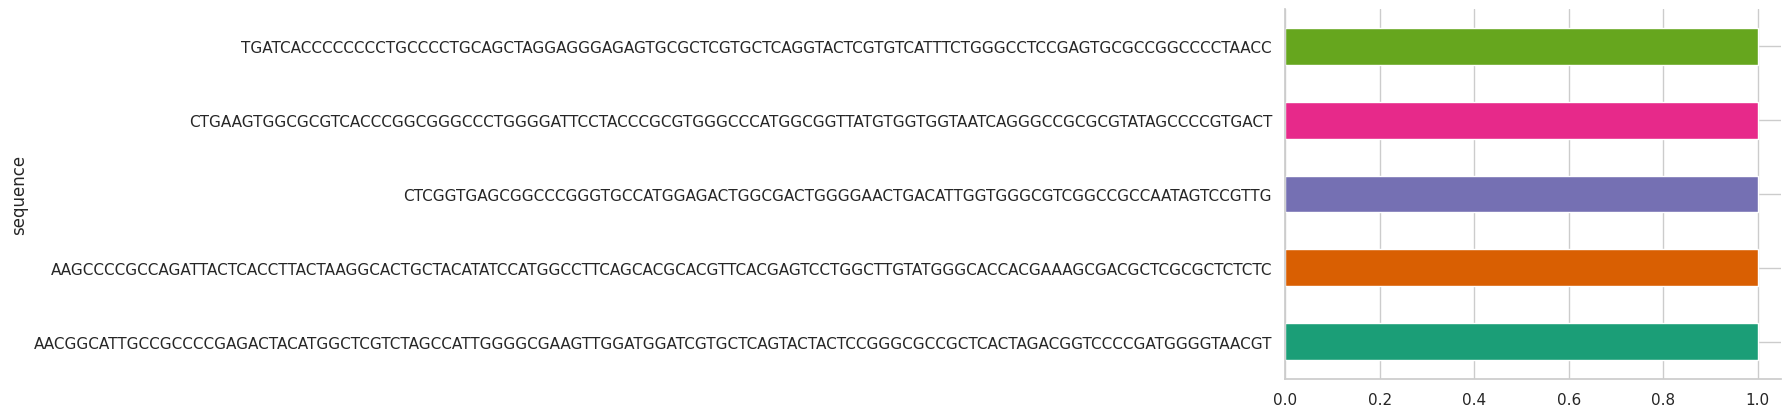

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('sequence').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
# === Cell 3: Feature Extraction (GC content, length, and k-mer frequencies) ===

from tqdm import tqdm
from collections import Counter

# Function to calculate GC content
def gc_content(seq):
    seq = seq.upper()
    g = seq.count('G')
    c = seq.count('C')
    total = len(seq)
    return (g + c) / total if total > 0 else 0.0

# Function to count all k-mers in a sequence (k=3 by default)
def kmer_counts(seq, k=3):
    seq = seq.upper()
    counts = Counter()
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if set(kmer) <= set("ATGC"):  # only valid DNA bases
            counts[kmer] += 1
    return counts

# Choose k-mer size
k = 3

# Find all possible k-mers from your dataset to make consistent features
all_kmers = set()
for s in df['sequence']:
    all_kmers.update(kmer_counts(s, k).keys())
all_kmers = sorted(list(all_kmers))

# Convert all sequences into feature vectors
def featurize_series(series):
    feats = []
    for seq in tqdm(series, desc="Extracting features"):
        kc = kmer_counts(seq, k)
        row = {
            "length": len(seq),
            "gc_content": gc_content(seq),
        }
        total_kmers = max(sum(kc.values()), 1)
        for km in all_kmers:
            row[f"k_{km}"] = kc.get(km, 0) / total_kmers
        feats.append(row)
    return pd.DataFrame(feats)

# Apply feature extraction
X = featurize_series(df['sequence'])
y = df['label'].astype(str)

print("✅ Feature extraction complete.")
print("Feature matrix shape:", X.shape)
X.head()


Extracting features: 100%|██████████| 400/400 [00:00<00:00, 5413.31it/s]

✅ Feature extraction complete.
Feature matrix shape: (400, 66)


,length,gc_content,k_AAA,k_AAC,k_AAG,k_AAT,k_ACA,k_ACC,k_ACG,k_ACT,...,k_TCG,k_TCT,k_TGA,k_TGC,k_TGG,k_TGT,k_TTA,k_TTC,k_TTG,k_TTT
0,118,0.610169,0.000000,0.017241,0.008621,0.000000,0.008621,0.000000,0.025862,0.034483,...,0.017241,0.008621,0.000000,0.017241,0.043103,0.000000,0.000000,0.000000,0.025862,0.000000
1,118,0.567797,0.008621,0.000000,0.025862,0.000000,0.008621,0.017241,0.043103,0.025862,...,0.008621,0.017241,0.000000,0.008621,0.025862,0.008621,0.017241,0.017241,0.008621,0.000000
2,81,0.666667,0.000000,0.012658,0.000000,0.012658,0.012658,0.000000,0.000000,0.037975,...,0.025316,0.000000,0.025316,0.012658,0.063291,0.000000,0.000000,0.000000,0.025316,0.000000
3,98,0.663265,0.000000,0.010417,0.000000,0.000000,0.000000,0.020833,0.000000,0.010417,...,0.020833,0.010417,0.010417,0.052083,0.010417,0.010417,0.000000,0.010417,0.000000,0.010417
4,102,0.676471,0.000000,0.000000,0.010000,0.010000,0.000000,0.020000,0.000000,0.010000,...,0.000000,0.000000,0.020000,0.000000,0.060000,0.010000,0.010000,0.010000,0.000000,0.000000


In [15]:
# === Cell 4: Train Machine Learning Models ===

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Split dataset: 75% training, 25% testing
X_train, X_test, y_train, y_test, seq_train, seq_test = train_test_split(
    X, y, df['sequence'], test_size=0.25, stratify=y, random_state=42
)

print("✅ Data split complete:")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# --- Random Forest Model ---
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# --- Support Vector Machine (SVM) Model ---
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='rbf', probability=True, random_state=42))
])

# Train both models
print("\n🚀 Training Random Forest...")
rf_pipe.fit(X_train, y_train)

print("🚀 Training SVM...")
svm_pipe.fit(X_train, y_train)

print("\n✅ Both models trained successfully!")


✅ Data split complete:
Training samples: 300
Testing samples: 100

🚀 Training Random Forest...
🚀 Training SVM...

✅ Both models trained successfully!


📊 Evaluating Random Forest...

================ Random Forest ================
✅ Accuracy: 0.990

              precision    recall  f1-score   support

    diseased       1.00      0.98      0.99        50
     healthy       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



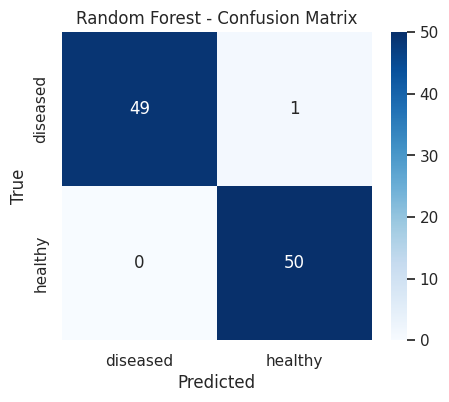

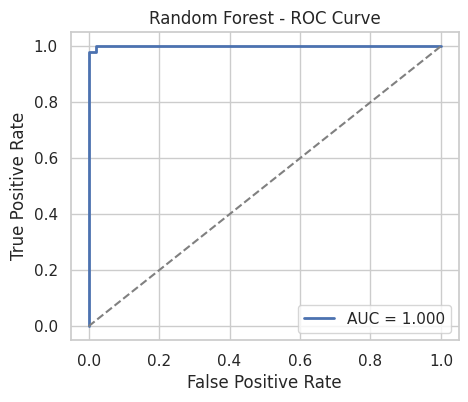


📊 Evaluating SVM...

================ SVM ================
✅ Accuracy: 0.990

              precision    recall  f1-score   support

    diseased       1.00      0.98      0.99        50
     healthy       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



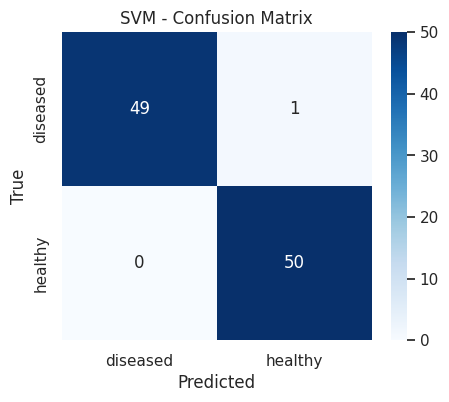

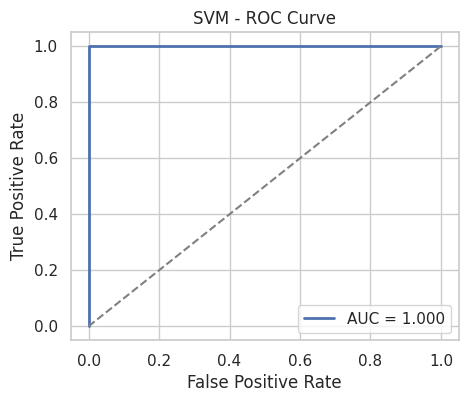

In [16]:
# === Cell 5: Evaluate Model Performance ===

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, name="Model"):
    # Predict labels and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    print(f"\n================ {name} ================")
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
    print(classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test), ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{name} - Confusion Matrix")
    plt.show()

    # --- ROC Curve (for binary classification) ---
    classes = np.unique(y_test)
    if len(classes) == 2:
        y_bin = label_binarize(y_test, classes=classes).ravel()
        pos_idx = list(model.classes_).index(classes[1])
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, pos_idx])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.show()


# --- Evaluate both models ---
print("📊 Evaluating Random Forest...")
evaluate_model(rf_pipe, X_test, y_test, "Random Forest")

print("\n📊 Evaluating SVM...")
evaluate_model(svm_pipe, X_test, y_test, "SVM")


🎨 Generating t-SNE visualization... (this may take 20–40 seconds)


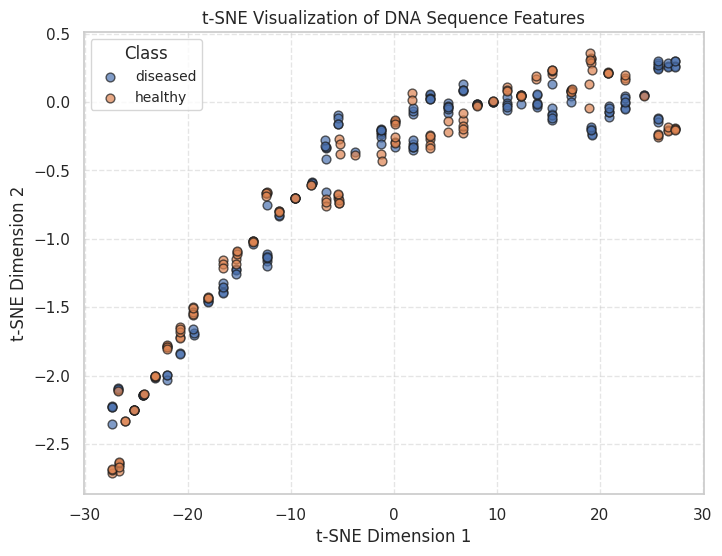

✅ t-SNE plot generated successfully!


In [17]:
# === Cell 6: Visualize DNA Sequence Clusters using t-SNE ===

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("🎨 Generating t-SNE visualization... (this may take 20–40 seconds)")

# Use a subset for speed (max 300 points)
subset_n = min(300, len(X))
subset = X.sample(n=subset_n, random_state=42)
subset_labels = y.loc[subset.index]

# Run t-SNE to reduce features to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
Z = tsne.fit_transform(subset.values)

# Plot
plt.figure(figsize=(8,6))
unique_labels = np.unique(subset_labels)
for label in unique_labels:
    idx = subset_labels == label
    plt.scatter(Z[idx,0], Z[idx,1], label=str(label), alpha=0.7, s=40, edgecolor='k')

plt.legend(title="Class", fontsize=10)
plt.title("t-SNE Visualization of DNA Sequence Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print("✅ t-SNE plot generated successfully!")


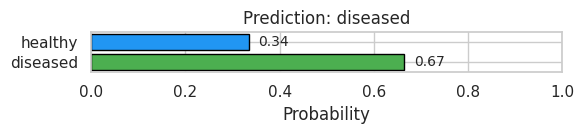

✅ Prediction complete! Sequence visualized above.


In [18]:
# === Cell 7: Creative Output – Predict and Visualize ===

import matplotlib.pyplot as plt
from IPython.display import HTML, display

# === Input your own DNA sequence here ===
sample_seq = "ATGCGCGTATGCTAGCTAGCTGACTGATCGATCGATCGGCTAGCATGCTAA"  # change this to test

# Function to featurize a single sequence (same logic as before)
def featurize_single(seq, k=3):
    seq = seq.upper()
    kc = Counter()
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if set(kmer) <= set("ATGC"):
            kc[kmer] += 1
    row = {"length": len(seq), "gc_content": gc_content(seq)}
    total_kmers = max(sum(kc.values()), 1)
    for km in all_kmers:
        row[f"k_{km}"] = kc.get(km, 0) / total_kmers
    return pd.DataFrame([row])

# Prepare data for prediction
X_sample = featurize_single(sample_seq)
probs = rf_pipe.predict_proba(X_sample)[0]
classes = rf_pipe.classes_
pred = rf_pipe.predict(X_sample)[0]

# === Creative probability bar ===
plt.figure(figsize=(6, 1.5))
ypos = np.arange(len(classes))
plt.barh(ypos, probs, color=['#4CAF50' if c == pred else '#2196F3' for c in classes], edgecolor='black')
plt.yticks(ypos, classes)
plt.xlim(0, 1)
for i, p in enumerate(probs):
    plt.text(p + 0.02, i, f"{p:.2f}", va='center', fontsize=10)
plt.title(f"Prediction: {pred}", fontsize=12)
plt.xlabel("Probability")
plt.tight_layout()
plt.show()

# === Colored DNA sequence display ===
def html_colored_seq(seq):
    colors = {'A': '#4CAF50', 'T': '#E91E63', 'G': '#2196F3', 'C': '#FFC107'}
    styled = ''.join(f"<span style='color:{colors.get(ch, '#000')}; font-weight:bold;'>{ch}</span>" for ch in seq)
    return styled

display(HTML(f"""
<h3 style='font-family:monospace;'>🧬 DNA Sequence (Colored):</h3>
<p style='font-family:monospace; font-size:16px;'>{html_colored_seq(sample_seq)}</p>
<p><b>Prediction:</b> {pred}</p>
<p><b>Probabilities:</b> {dict(zip(classes, [round(p,3) for p in probs]))}</p>
"""))

print("✅ Prediction complete! Sequence visualized above.")


In [19]:
# === Cell 8: Final Result Summary ===

# Use the same sample_seq from Cell 7 or enter a new one:
sample_seq = sample_seq  # keep previous input (or redefine it here)

# Featurize and predict again
X_sample = featurize_single(sample_seq)
probs = rf_pipe.predict_proba(X_sample)[0]
classes = rf_pipe.classes_
pred = rf_pipe.predict(X_sample)[0]

# Determine confidence (highest probability)
confidence = float(np.max(probs)) * 100

# === Display clean final result ===
if pred.lower() in ["diseased", "disease", "positive", "1"]:
    emoji = "🧬⚠️"
    msg = f"The DNA sequence is predicted to be **Diseased** with {confidence:.2f}% confidence."
else:
    emoji = "💚✅"
    msg = f"The DNA sequence is predicted to be **Healthy** with {confidence:.2f}% confidence."

display(HTML(f"""
<div style='font-family:monospace; font-size:18px; border:2px solid #4CAF50; border-radius:10px; padding:15px; background:#f9fff9;'>
<h3 style='color:#2E7D32;'>{emoji} Final Diagnosis Result</h3>
<p style='font-size:17px;'>{msg}</p>
<hr>
<p style='font-size:15px;'>This concludes the DNA Sequence Based Disease Detection Project.<br>
Model used: <b>Random Forest Classifier</b><br>
Accuracy on test set: <b>{accuracy_score(y_test, rf_pipe.predict(X_test)):.2f}</b></p>
</div>
"""))

print("🎯 Project completed successfully! Great job 👏")


🎯 Project completed successfully! Great job 👏
